In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)
%cd /content/drive

Mounted at /content/drive
/content/drive


In [2]:
!pip install unidecode
!pip install fasttext

     |████████████████████████████████| 245kB 8.1MB/s 
     |████████████████████████████████| 71kB 5.0MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp36-cp36m-linux_x86_64.whl size=3041398 sha256=fd8f02e8def8e5d2a9f404e194697f852e6ceabec399a0ea4de69fa320cd43bc
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext


# IMPORTS

Here all imports are carried out for the whole projects.

In [3]:
#########################################
############### IMPORTS #################
#########################################

import sys
sys.path.append('/content/drive/MyDrive/DL_Corti/code/')
data_path = "/content/drive/MyDrive/DL_Corti/data/"

import pandas as pd
import numpy as np
import unidecode
import re
import string

from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer

from sklearn.feature_extraction.text import TfidfVectorizer

from typing import *
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import seaborn as sns
import random

sns.set_style("whitegrid")

import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.distributions import Distribution
from scipy.sparse import coo_matrix
from plotting_rnn import make_vae_plots

from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.transforms import ToTensor
from functools import reduce

import fasttext

# from importDatasets import mUSA_train, mUSA_test, tfidf_politic, tfidf_UK

## Functions to clean

In [4]:
class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()
        
    def sample_epsilon(self) -> Tensor:
        """`\eps ~ N(0, I)`"""
        return torch.empty_like(self.mu).normal_()
        
    def sample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (without gradients)"""
        with torch.no_grad():
            return self.rsample()
        
    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        return self.mu + self.sigma*self.sample_epsilon() # <- your code
        #: let z ∼ p(z|x) = N (µ, σ2). In this case, a valid reparameterization is z = µ + σ eps, where eps is an auxiliary noise variable eps - N (0, 1).
   
    def log_prob(self, z:Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
       # d=Normal(loc=self.mu, scale=self.sigma)
        return  -((z - self.mu)** 2) / (2 * self.sigma**2) - self.sigma.log() -math.log(math.sqrt(2 * math.pi))  # <- your code
    
    
from torch.distributions import Bernoulli #<- your code
p = Bernoulli(logits=torch.zeros((1000,)))
# plt.figure(figsize=(12, 3))
# sns.distplot(p.sample())
# plt.title(r"$\mathcal{B}(\mathbf{y} \mid \mathbf{\theta})$")
# plt.show() 

In [5]:
from functools import reduce 
from importDatasets_rnn import train_loader, test_loader , test_loader_politic  , test_loader_UK, embeding_matching,y,wordEmbedingModel,batch_size

print(y)
# Load a batch of images into memory
batch = next(iter(train_loader))

# for i, ax in enumerate(axarr.flat):
#     ax.spy(tfidf_m[i])
#     ax.axis('off')
    
# plt.show()
            
#########################################################################################################################


class VariationalAutoencoder(nn.Module):
    """A Variational Autoencoder with
    * a Bernoulli observation model `p_\theta(x | z) = B(x | g_\theta(z))`
    * a Gaussian prior `p(z) = N(z | 0, I)`
    * a Gaussian posterior `q_\phi(z|x) = N(z | \mu(x), \sigma(x))`
    """
    
    def __init__(self, input_shape:torch.Size, latent_features:int, vocab_size:int, embedding_size:int, rnn_type, hidden_size:int, num_layers:int, bidirectional=False) -> None:
        super(VariationalAutoencoder, self).__init__()
        
        self.input_shape = input_shape
        self.vocab_size=vocab_size
        self.embedding_size = embedding_size
        self.latent_features = latent_features
        self.observation_features = np.prod(input_shape)
        
        self.rnn_type = rnn_type
        self.bidirectional = bidirectional
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        # self.word_dropout_rate = word_dropout
        # self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        if rnn_type == 'rnn':
            rnn = nn.RNN
        elif rnn_type == 'gru':
            rnn = nn.GRU
        elif rnn_type == 'lstm':
            rnn = nn.LSTM
        else:
            raise ValueError()

        self.hidden_factor = (2 if bidirectional else 1) * num_layers
        # Inference Network
        # Encode the observation `x` into the parameters of the posterior distribution
        # `q_\phi(z|x) = N(z | \mu(x), \sigma(x)), \mu(x),\log\sigma(x) = h_\phi(x)`
        
        self.encoder_rnn =  rnn(embedding_size, hidden_size, num_layers=num_layers, bidirectional=self.bidirectional,
                               batch_first=True)
        self.hidden2rep = nn.Linear(hidden_size * self.hidden_factor, latent_features*2)
        # Generative Model
        # Decode the latent sample `z` into the parameters of the observation model
        # `p_\theta(x | z) = \prod_i B(x_i | g_\theta(x))`
        self.latent2hidden = nn.Linear(latent_features, hidden_size * self.hidden_factor * vocab_size )
        self.decoder_rnn = rnn(embedding_size, hidden_size, num_layers=num_layers, bidirectional=self.bidirectional,
                               batch_first=True)
        self.outputs2vocab = nn.Linear(hidden_size * self.hidden_factor * vocab_size ,
                                       hidden_size  * vocab_size )

        # define the parameters of the prior, chosen as p(z) = N(0, I)
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))
        
    def posterior(self, x:Tensor) -> Distribution:
        """return the distribution `q(x|x) = N(z | \mu(x), \sigma(x))`"""
        
        # compute the parameters of the posterior
        
        _, h_x = self.encoder_rnn(x)
        
        if self.bidirectional or self.num_layers > 1:
            # flatten hidden state
            h_x = h_x.view(x.shape[0], self.hidden_size * self.hidden_factor)
        else:
            h_x = h_x.squeeze()
            
        h_x = self.hidden2rep(h_x)
        mu, log_sigma =  h_x.chunk(2, dim=-1)
        
        # return a distribution `q(x|x) = N(z | \mu(x), \sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def prior(self, batch_size:int=1)-> Distribution:
        """return the distribution `p(z)`"""
        prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = prior_params.chunk(2, dim=-1)
        
        # return the distribution `p(z)`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def observation_model(self,x, z:Tensor) -> Distribution:
        """return the distribution `p(x|z)`"""
        
        h_x = self.latent2hidden(z)
        
        if self.bidirectional or self.num_layers > 1:
            # unflatten hidden state
            h_x = h_x.view(x.shape[0], self.hidden_size * self.hidden_factor * self.vocab_size)
         #else:
             # h_x= h_x.reshape(batch_size, h_x.shape[1])
             #h_x= h_x.unsqueeze(0)
        h_x=torch.tanh(h_x)
        h_x=self.outputs2vocab(h_x)
        h_x= h_x.reshape(h_x.shape[0],self.vocab_size,self.embedding_size)
        #outputs,_ = self.decoder_rnn(x, h_x)
        
        x_logits = torch.softmax(h_x,-1)
        return Bernoulli(logits=x_logits)
        
        #outputs.reshape(-1, outputs.size(2))
        #outputs.reshape(outputs.size(0),-1)
        #x_logits = self.outputs2vocab(outputs.view(-1, outputs.size(2))) # reshape the output
        #b,s,_ = outputs.size()
        # project outputs to vocab
        #logp = nn.functional.log_softmax(self.outputs2vocab(outputs.reshape(outputs.size(0),-1)), dim=-1)
        #return logp.view(b, s, self.embedding_size)
    
    # def sample_from_prior(self, batch_size:int=100):
    #     """sample z~p(z) and return p(x|z)"""
    #     # degine the prior p(z)
    #     pz = self.prior(batch_size=batch_size)
    #     # sample the prior 
    #     z = pz.rsample()
    #     # define the observation model p(x|z) = B(x | g(z))
    #     px = self.observation_model(z)
    #     return {'px': px, 'pz': pz, 'z': z}

    def forward(self, x) -> Dict[str, Any]:
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""
        
        # flatten the input
        #x = x.view(x.size(0), -1)
        
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x) 
        
        # define the prior p(z)
        pz = self.prior(batch_size=x.size(0))
        
        # REPARAMETERIZATION
        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(x,z)
        
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}
    
    



###########################################################################################################################


def reduce(x:Tensor) -> Tensor:
    """for each datapoint: sum over all dimensions"""
    return x.view(x.size(0), -1).sum(dim=1)

class VariationalInference(nn.Module):
    def __init__(self, beta:float=1.):
        super().__init__()
        self.beta = beta
        
    def forward(self, model:nn.Module, x:Tensor) -> Tuple[Tensor, Dict]:
        
        # forward pass through the model
        outputs = model(x)
        
        # unpack outputs
        px, pz, qz, z = [outputs[k] for k in ["px", "pz", "qz", "z"]]
        
        # evaluate log probabilities
        log_px = reduce(px.log_prob(x))
        log_pz = reduce(pz.log_prob(z))
        log_qz = reduce(qz.log_prob(z))
        
        # compute the ELBO with and without the beta parameter: 
        # L = E_q [ log p(x|z) -  D_KL(q(z|x) | p(z))`
        # `L^\beta = E_q [ log p(x|z) - \beta * D_KL(q(z|x) | p(z))`
        # where `D_KL(q(z|x) | p(z)) = log q(z|x) - log p(z)`
        kl = log_qz - log_pz
        elbo = log_px - kl  # <- your code here
        beta_elbo = log_px - (self.beta*kl) # <- your code here
        
        # loss
        loss = -beta_elbo.mean()
        
        # prepare the output
        with torch.no_grad():
            diagnostics = {'elbo': elbo, 'log_px':log_px, 'kl': kl}
            
        return loss, diagnostics, outputs
        
from collections import defaultdict
# define the models, evaluator and optimizer

##########################################################################################################################



/content/drive/MyDrive/DL_Corti/code/importDatasets_rnn.py:209: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  matching2 = df_politic[df_tweetUK['text'].str.contains(cat2)]


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3]


/content/drive/MyDrive/DL_Corti/code/importDatasets_rnn.py:210: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  matching3 = df_politic[df_tweetUSA['text'].str.contains(cat3)]


>> Using device: cuda:0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
latent_features = 512 | beta=10  |  learning_rate=0.0001 


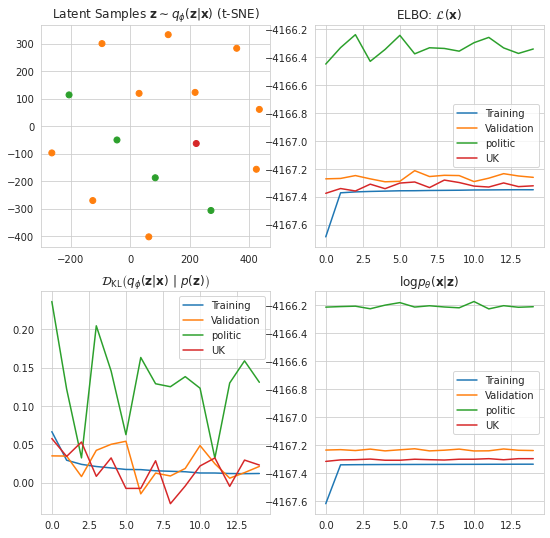

loss   | mean =   4167.454, shape: []
elbo   | mean =  -4167.261, shape: [64]
log_px | mean =  -4167.240, shape: [64]
kl     | mean =      0.021, shape: [64]



epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
latent_features = 512 | beta=10  |  learning_rate=0.001 


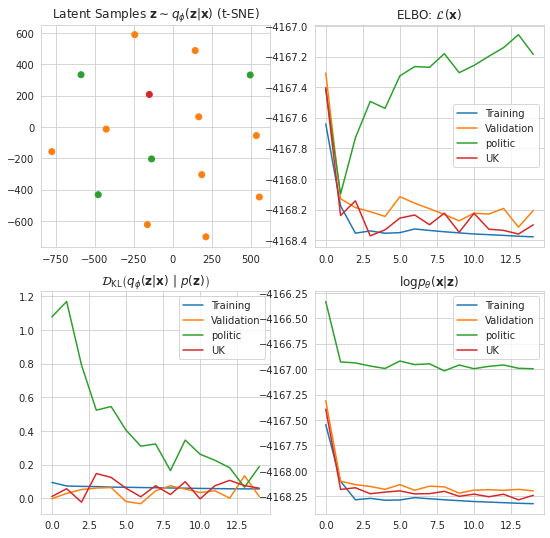

loss   | mean =   4168.291, shape: []
elbo   | mean =  -4168.206, shape: [64]
log_px | mean =  -4168.196, shape: [64]
kl     | mean =      0.009, shape: [64]





In [6]:

num_epochs =15

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")


Latent_features=[ 512]
Betas=[ 10]
Learning_rates=[0.0001, 0.001]

for latent_features in Latent_features:
  for beta in Betas:
    for learning_rate in Learning_rates:

      # define dictionary to store the training curves
      training_data = defaultdict(list)
      validation_data = defaultdict(list)
      validation_data_politic = defaultdict(list)
      validation_data_UK = defaultdict(list)

      epoch = 0
      vae = VariationalAutoencoder(input_shape=batch[0].shape,
                             latent_features=latent_features,
                             vocab_size=20,
                             embedding_size=300,
                             rnn_type='gru',
                             hidden_size=300,
                             num_layers=1,
                             bidirectional=False)
      # print(vae)

      vi = VariationalInference(beta=beta)

      # The Adam optimizer works really well with VAEs.
      optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)
      # move the model to the device
      # move the model to the device
      vae = vae.to(device)
      matches=embeding_matching.to(device)

      # training..
      while epoch < num_epochs:
          epoch+= 1
          print("epoch "+str(epoch))
          training_epoch_data = defaultdict(list)
          vae.train()
          
          # Go through each batch in the training dataset using the loader
          # Note that y is not necessarily known as it is here

          for x in train_loader:
              x = x.to(device)
              
              # perform a forward pass through the model and compute the ELBO
              loss, diagnostics, outputs = vi(vae, x)
              
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
              
              # gather data for the current bach
              for k, v in diagnostics.items():
                  training_epoch_data[k] += [v.mean().item()]

          # gather data for the full epoch
          if(epoch>-1):
              for k, v in training_epoch_data.items():
                  training_data[k] += [np.mean(training_epoch_data[k])]

          # Evaluate on a single batch, do not propagate gradients
          with torch.no_grad():
              vae.eval()
              
              # Just load a single batch from the test loader
              x = next(iter(test_loader))
              x = x.to(device)
              
              # perform a forward pass through the model and compute the ELBO
              loss, diagnostics, outputs = vi(vae, x)
              
              x_politic = next(iter(test_loader_politic))
              x_politic= x_politic.to(device)
              
              # # perform a forward pass through the model and compute the ELBO
              loss_politic, diagnostics_politic, outputs_politic = vi(vae, x_politic)
              
              x_UK = next(iter(test_loader_UK))
              x_UK = x_UK.to(device)
              
              # # perform a forward pass through the model and compute the ELBO
              loss_UK, diagnostics_UK, outputs_UK = vi(vae, x_UK)
              # # gather data for the validation step
              
              loss_matches, diagnostics_matches, outputs_matches = vi(vae, matches)
              
              # gather data for the validation step
              if(epoch>-1):
                  for k, v in diagnostics.items():
                      validation_data[k] += [v.mean().item()]
                  for k, v in diagnostics_politic.items():
                      validation_data_politic[k] += [v.mean().item()]
                  for k, v in diagnostics_UK.items():
                      validation_data_UK[k] += [v.mean().item()]
                  
      print(f"latent_features = {latent_features} | beta={beta}  |  learning_rate={learning_rate} ")
      make_vae_plots(vae, x, y, outputs, outputs_matches, training_data, validation_data,validation_data_politic,validation_data_UK)
          ##Reproduce the figure from the begining of the notebook, plot the training curves and show latent samples
          #if(epoch>-1):
              #make_vae_plots(vae, x, y, outputs, outputs_matches, training_data, validation_data)
              
              #make_vae_plots(vae, x, y, outputs, outputs_matches, training_data, validation_data,validation_data_politic,validation_data_UK)

      print(f"{'loss':6} | mean = {loss:10.3f}, shape: {list(loss.shape)}")
      for key, tensor in diagnostics.items():
          print(f"{key:6} | mean = {tensor.mean():10.3f}, shape: {list(tensor.shape)}")
      print("\n\n")

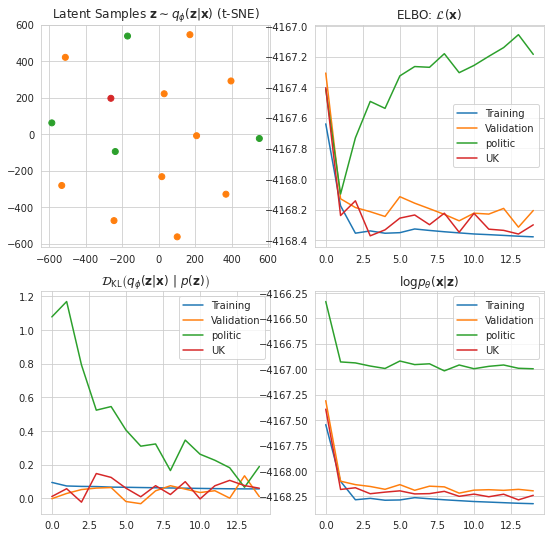

loss   | mean =   4169.768, shape: []
elbo   | mean =  -4168.342, shape: [64]
log_px | mean =  -4168.184, shape: [64]
kl     | mean =      0.158, shape: [64]
 as a father of six and a grandfather of i can only imagine the great pain of the parents and
 rescheduled UFA Tagalog Harder Reformed Polish-Lithuanian apiece Aggie noon Harder Eisler Rare Deaf Plattsburgh Syriac Spoken denominated buttoned noon ideologically
0
 before the chicago take on the the new york times examines my love for the game and my effort with
 Ordered Fowl feign Depends Grit Tagalog Executed Invalid matinee idiomatic Joni roped Octagon Selina Cochabamba Thirsty Lowest Batavia Oda Harder
1
 you have to agree with to love her. she was , , , , , , , , , ,
 swill Octagon Brandt handicraft Harder Conant Kaori rescheduled Philippi Doubtful Kapp Maccabees Kaori Oda Declared gastritis Panay patricians declined replaceable
2
 that is so love to in today though so i please wish everyone happy holidays for me. , , ,
 Depend

IndexError: ignored

In [7]:
make_vae_plots(vae, x, y, outputs, outputs_matches, training_data, validation_data,validation_data_politic,validation_data_UK)
loss, diagnostics, outputs = vi(vae, x)

print(f"{'loss':6} | mean = {loss:10.3f}, shape: {list(loss.shape)}")
for key, tensor in diagnostics.items():
    print(f"{key:6} | mean = {tensor.mean():10.3f}, shape: {list(tensor.shape)}")
    
    
    
loss_matches, diagnostics_matches, outputs_matches = vi(vae, matches)
px=outputs_matches['px']
output=px.sample()
matchescpu=matches.cpu()
outputcpu=output.cpu()


#print(pz)
#print(qz)
for i in range(30) :
    originalSentence=""
    reconstructedSentence=""
    for j in range(20):
        originalSentence+=" "+wordEmbedingModel.similar_by_vector(matchescpu[i][j].numpy(),1)[0][0]
        reconstructedSentence+=" "+wordEmbedingModel.similar_by_vector(outputcpu[i][j].numpy(),1)[0][0]
    print(originalSentence)
    print(reconstructedSentence)
    print(i)